Modelo de clasificación de imágenes multiple con transferencia de aprendizaje
==============================================================================

<div class="admonition warning">PRECAUCIÓN 😱: El tema presentado en esta sección está clasificado como avanzado. El entendimiento de este contenido es totalmente opcional.</div>

### Preparación del ambiente

Intalamos las librerias necesarias

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/vision/tasks/classification/code/cnn_mclass_transfer_learning.txt \
    --quiet --no-clobber
!pip install -r cnn_mclass_transfer_learning.txt --quiet

Descargamos el conjunto de datos

> **Nota:** Note que estamos descargando el conjunto de datos completo de imágenes en este ejemplo. Si quiere utilizar un conjunto de datos más chico, puede cambiar donde dice `imdb-movie-gull.zip` por `imdb-movie.zip`.

In [ ]:
!wget https://santiagxf.blob.core.windows.net/public/imdb-movie-genre-full.zip \
    --quiet --no-clobber --directory-prefix ./Datasets/
!unzip -o -qq ./Datasets/imdb-movie-genre-full.zip -d Datasets

Verifiquemos el tamaño del conjunto de datos

In [ ]:
!ls Datasets/SampleMoviePosters | wc -l

36337


En caso de que quiera descargar todo el conjunto de datos de imágenes puede utilizar el siguiente codigo para descargar las imagenes dadas sus URLs (aproximadamente 40K imagenes). Su uso es:

```
donwload_all(data)
```

In [ ]:
import urllib

def download_file(download_url, filename):
    try:
        response = urllib.request.urlopen(download_url)    
    except urllib.error.HTTPError:
        return False
    
    file = open(filename, 'wb')
    file.write(response.read())
    file.close()
    
    return True

def donwload_all(data):
    data['Downloaded'] = False
    
    from tqdm import tqdm

    for index, row in tqdm(data.iterrows()):
        data['Downloaded'][index] = download_file(row['Poster'], row['Image'])

### Sobre el conjunto de datos de este ejemplo

Este conjunto de datos proviene de [Kaggle](https://www.kaggle.com/neha1703/movie-genre-from-its-poster) y contiene carteles (posters) de películas del [sitio web de IMDB](https://www.imdb.com /). Este conjunto de datos contiene la siguiente información para cada película: 

 - ID de IMDB
 - enlace de IMDB
 - título
 - puntuación de IMDB
 - género
 - un enlace para descargar el póster de la película
 
En este conjunto de datos, cada póster de película puede pertenecer al menos a un género y puede tener como máximo 3 etiquetas asignadas. El número total de carteles ronda los 40K.

In [ ]:
import pandas as pd

data = pd.read_csv("Datasets/MovieGenre.csv", encoding = "ISO-8859-1").dropna()
data['Image'] = "Datasets/SampleMoviePosters/" + data["imdbId"].astype(str) + ".jpg"
data['Genre'] = data['Genre'].apply(lambda x: x.split("|"))

In [ ]:
data.head(5)

,Unnamed: 0,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Downloaded,Image
0,0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...,True,Datasets/SampleMoviePosters/114709.jpg
1,1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...,True,Datasets/SampleMoviePosters/113497.jpg
2,2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...,True,Datasets/SampleMoviePosters/113228.jpg
3,3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...,True,Datasets/SampleMoviePosters/114885.jpg
4,4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...,True,Datasets/SampleMoviePosters/113041.jpg


Filtraremos el conjunto de datos solo por aquellas imágenes que están disponible. La columna "Downloaded" indica esta información.

In [ ]:
images = data[data['Downloaded'] == True]["Image"].to_numpy()
labels = data[data['Downloaded'] == True]["Genre"].to_numpy()

## Preparación de los datos

Primero debemos generar las etiquetas que se utilizarán para el modelo de clasificación. Dado que este es un problema de clasificación multiple, utilizaremos `MultiLabelBinarizer`:

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

label_encoder = MultiLabelBinarizer()
labels = label_encoder.fit_transform(labels)

In [ ]:
N_LABELS = len(label_encoder.classes_)

Dividimos el conjunto de datos en entrenamiento y testing:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3)

Configuramos algunos parámetros de las imágenes

In [ ]:
IMG_SIZE = 224 # Tamaño en pixeles de las imágenes
CHANNELS = 3 # Numero de canales. RGB = 3
BATCH_SIZE = 128 # Tamaño del lote para entrenamiento
SHUFFLE_BUFFER_SIZE = 1024 # Mezclaremos el conjunto de datos en lotes de 1024 imágenes

Definimos una función para leer las imágenes de los directorios:

In [ ]:
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE

def parse_image(filename, labels, CHANNELS:int=3, IMG_SIZE:int=224):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0

    return image_normalized, labels

Definimos una función para generar el conjunto de datos:

In [ ]:
def create_dataset(filenames, labels, is_training=True, cache=False):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
      if cache:
        # Utilice caching solo si el dataset es pequeño y cabe en memoria
        dataset = dataset.cache()
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

Instanciamos nuestros conjuntos de datos de entrenamiento y testing:

In [ ]:
train_ds = create_dataset(X_train, y_train, is_training=True)
test_ds = create_dataset(X_test, y_test, is_training=False)

In [ ]:
dataset = train_ds.take(1)
for x, y in dataset.as_numpy_iterator():
  print(x.shape)

(128, 224, 224, 3)


## Utilizando transferencia de aprendizaje en nuestro modelo

### ¿Qué es TensorFlow Hub?

Un concepto que es esencial en el desarrollo de software es la idea de reutilizar el código que está disponible a través de librerías. Las librerías hacen que el desarrollo sea más rápido y generan más eficiencia. Para los cientificos de datos que trabajan en visión artificial, entrenar arquitecturas de redes neuronales complejas desde cero resulta altamente complejo. TensorFlow Hub es una biblioteca que permite publicar y reutilizar componentes de aprendizaje automático prediseñados. Con TF.Hub, resulta sencillo volver a entrenar la capa superior de un modelo previamente entrenado para reconocer las clases en un nuevo conjunto de datos. TensorFlow Hub también distribuye modelos sin la capa de clasificación. Estos se pueden utilizar para realizar fácilmente el aprendizaje por transferencia. Puede descargar cualquier [modelo para imágenes compatible con Tensorflow 2 de tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2). La única condición es asegurarse de que la forma de las características de la imagen en nuestro conjunto de datos preparado coincida con la forma de entrada esperada del modelo que desea reutilizar.

### Utilizando un modelo para transferencia de aprendizaje

Usaremos una instancia previamente entrenada de MobileNetV2 y un tamaño de entrada de 224x224. MobileNetV2 es en realidad una gran familia de arquitecturas de redes neuronales que se diseñaron principalmente para acelerar la inferencia en el dispositivo celular. Vienen en diferentes tamaños según el multiplicador de profundidad (número de características en capas convolucionales ocultas) y el tamaño de las imágenes de entrada.

In [ ]:
import tensorflow_hub as hub

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

El extractor que estamos usando aquí acepta imágenes de forma (224, 224, 3) y devuelve un vector de 1280 de longitud para cada imagen. Para evitar que TensorFlow intente ajustar los pesos de esta parte del modelo, debemos congelar los pesos en la capa del extractor, de modo que el entrenamiento solo modifique las capas de clasificación. Por lo general, esto es una buena práctica cuando se trabaja con conjuntos de datos que son muy pequeños en comparación con el conjunto de datos original en el que se entrenó el extractor de predictor. Solo se recomienda entrenarla si el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos de ImageNet original.

In [ ]:
feature_extractor_layer.trainable = False

Generamos el modelo agregando un clasificador:

In [ ]:
import tensorflow.keras as keras
import tensorflow_addons as tfa

model = keras.Sequential([
    feature_extractor_layer,
    keras.layers.Dense(1024, activation='relu', name='hidden_layer'),
    keras.layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
  loss='binary_crossentropy',
  metrics=[tf.keras.metrics.categorical_accuracy])

Entrenamos el modelo:

In [ ]:
EPOCHS = 10

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/10
202/202 [==============================] - 85s 406ms/step - loss: 0.3871 - categorical_accuracy: 0.1850 - val_loss: 0.2406 - val_categorical_accuracy: 0.2630
Epoch 2/10
202/202 [==============================] - 83s 402ms/step - loss: 0.2259 - categorical_accuracy: 0.2778 - val_loss: 0.2206 - val_categorical_accuracy: 0.2837
Epoch 3/10
202/202 [==============================] - 83s 403ms/step - loss: 0.2142 - categorical_accuracy: 0.3003 - val_loss: 0.2133 - val_categorical_accuracy: 0.3045
Epoch 4/10
202/202 [==============================] - 83s 400ms/step - loss: 0.2080 - categorical_accuracy: 0.3169 - val_loss: 0.2085 - val_categorical_accuracy: 0.3197
Epoch 5/10
202/202 [==============================] - 82s 399ms/step - loss: 0.2035 - categorical_accuracy: 0.3300 - val_loss: 0.2050 - val_categorical_accuracy: 0.3290
Epoch 6/10
202/202 [==============================] - 82s 397ms/step - loss: 0.2002 - categorical_accuracy: 0.3394 - val_loss: 0.2025 - val_categorical_acc

Generamos las predicciones para evaluar el modelo

In [ ]:
import numpy as np

y_prob = model.predict(test_ds)
y_pred = np.round(y_prob)

Generamos una matriz de confusión para todas las etiquetas

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y_test, y_pred)

### Verificando los resultados

Dado que se trata de un problema de clasificación multiple, utilizaremos una matriz de confusión multiple para verificar la performance de nuestro modelo. La siguiente función intentará graficar esta información para poder verificarla más facilmente:

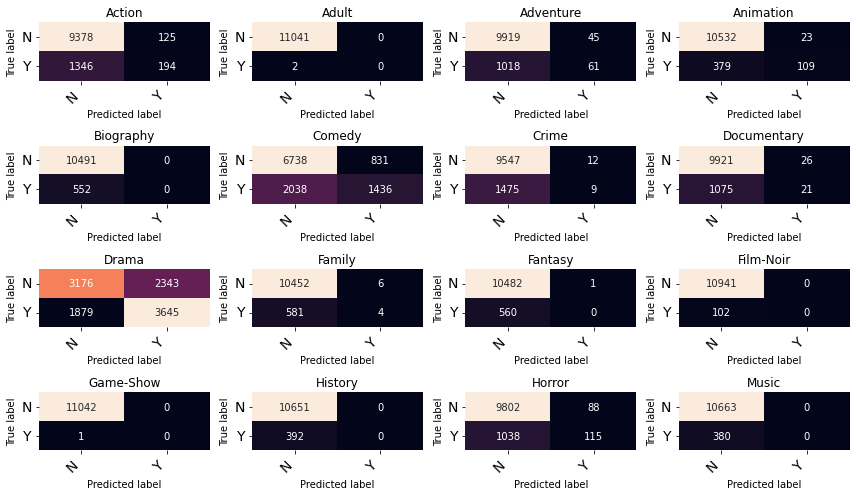

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

fig, ax = plt.subplots(4, 4, figsize=(12, 7))  
for axes, cfs_matrix, label in zip(ax.flatten(), cm, label_encoder.classes_):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

### Persisitendo el modelo

Guardamos el modelo en caso de que lo necesitemos más tarde:

In [ ]:
from datetime import datetime
t = datetime.now().strftime("%Y%m%d_%H%M%S")
export_path = "./Models/imbd-mclass_{}.h5".format(t)
model.save(export_path)
print("Modelo almacenado en: '{}'".format(export_path))

Modelo almacenado en: './Models/imbd-mclass_20211011_051505.h5'


Luego podemos cargarlo nuevamente como sigue:

In [ ]:
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})